In [1]:
import sys
sys.path.insert(0, '')

from pytket.circuit.display import render_circuit_jupyter
from pytket.extensions.qiskit import tk_to_qiskit
from lambeq.lambeq import (BobcatParser,
                    pregroups,
                    Rewriter,
                    AtomicType,
                    IQPAnsatz,
                    remove_cups,
                    TketModel,
                    BinaryCrossEntropyLoss,
                    QuantumTrainer,
                    SPSAOptimizer,
                    Dataset,
                    BaseAnsatz,
                    NumpyModel)


from discopy.drawing import Equation
from pytket.extensions.qiskit import AerBackend
from qiskit_ibm_provider import IBMProvider
from qiskit_aer.noise import NoiseModel

import matplotlib.pyplot as plt


# ## Quantum Training

import os
import warnings
import numpy as np

from dask.distributed import Client, LocalCluster

# For use on Wahab
#from dask_jobqueue import SLURMCluster

After importing everything we require, we also need a utility function to read the datasets. These datasets can be found in the ./data/ directory and are titled with the number of words per sentence and separated by train and test sets. We are using a sentiment analysis dataset comprised of positive or negative tags. The 6, 8, and 10 word sentences were created by ChatGPT, checked for sentence size and DisCoCat criteria, then formatted for easy reading. Some examples of the 6 word sentences are shown below:

0 Loneliness creeps in, darkening everything inside .\
1 Laughter echoes, lifting spirits and moods .

In [2]:
# Utility function to read data and filter any sentences that are
# an incorrect size
def read_data(filename, size):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            sentences.append(line[1:].strip())
            if len(sentences[-1].split()) == size + 1:
                t = int(line[0])
                labels.append([t, 1-t])
            else:
                # Check sentence size produced by ChatGPT
                print("Sentence is incorrect size:\n",sentences[-1])
                sentences.pop()

    return labels, sentences

If you have an IBM account, you can load data from real quantum devices to train your models. More on how to do that can be found [here](https://docs.quantum.ibm.com/api/qiskit-ibm-provider/qiskit_ibm_provider.IBMProvider).

In [3]:
#IBMProvider.save_account(token='your-account-token')

'''
provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')
noise_model = NoiseModel.from_backend(backend)

backend = AerBackend()
backend_config = {'backend': backend,
                  'compilation': backend.default_compilation_pass(2),
                  'noise_model': noise_model,
                  'shots': 1024, 
                  'probabilities': True}
'''

# Noiseless backend for Tket models
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}

If running the training on Wahab, we need to initialize the adaptive cluster. Otherwise, for a local machine the LocalCluster method works here as well. In addition, we need to initialize some variables for training. The batch size, number of epochs, and sentence size will determine several aspects of the model. The seed is used for training the numpy simulator so we can recreate results without variance to the output if we choose. This is helpful for considering small adjustments to hypterparameters in a particular model.

NOTE: You cannot execute a slurm model from within a standard jupyter notebook. Dask utilizes multithreading and requires protection. The simple way is to put the code under an *if \_\_name__ == "\_\_main__":* script statement. It is also possible to use the Dask jupyter lab extension found [here](https://github.com/dask/dask-labextension). The extension does not run on Wahab itself but on your local machine, while the slurm job is portered through to your notebook. It requires some set up but it is a useful tool that yields interesting results.

In [4]:
#cluster = SLURMCluster(cores=36, memory='24GB', interface='ib0')
#cluster.adapt(minimum=2, maximum=5)
#cluster = LocalCluster()

os.environ['TOKENIZERS_PARALLELISM'] = 'true'

BATCH_SIZE = 10
EPOCHS = 100
SEED = 2
sentence_size = 6

Now, we will read in the dataset and transform the sentences into DisCoCat diagrams.

In [5]:
train_labels, train_data = read_data(f'./data/{sentence_size}_train.txt', sentence_size)
test_labels, test_data = read_data(f'./data/{sentence_size}_test.txt', sentence_size)


parser = BobcatParser(root_cats=('NP', 'N'), verbose='text')

raw_train_diagrams = parser.sentences2diagrams(train_data, suppress_exceptions=True)
raw_test_diagrams = parser.sentences2diagrams(test_data, suppress_exceptions=True)

train_diagrams = [
    diagram.normal_form()
    for diagram in raw_train_diagrams if diagram is not None
]
test_diagrams = [
    diagram.normal_form()
    for diagram in raw_test_diagrams if diagram is not None
]

train_labels = [
    label for (diagram, label)
    in zip(raw_train_diagrams, train_labels)
    if diagram is not None]
test_labels = [
    label for (diagram, label)
    in zip(raw_test_diagrams, test_labels)
    if diagram is not None
]

Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


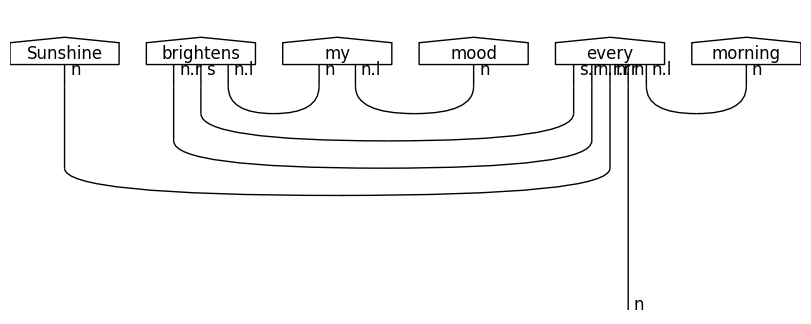

In [6]:
pregroups.draw(train_diagrams[0], figsize=(14,3), fontsize=12)

Now that we have a DisCoCat diagram of each sentence, we can transform that into a circuit. For this, I have chosen a simple model of 1 qubit per noun and sentence type as well as a single layer of the circuit itself.

In [7]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 0},
                    n_layers=1, n_single_qubit_params=1)


train_circuits = [ansatz(remove_cups(diagram)) for diagram in train_diagrams]
test_circuits =  [ansatz(remove_cups(diagram))  for diagram in test_diagrams]

train_dataset = Dataset(
                train_circuits,
                train_labels,
                batch_size=BATCH_SIZE)

test_dataset = Dataset(test_circuits, test_labels, shuffle=False)

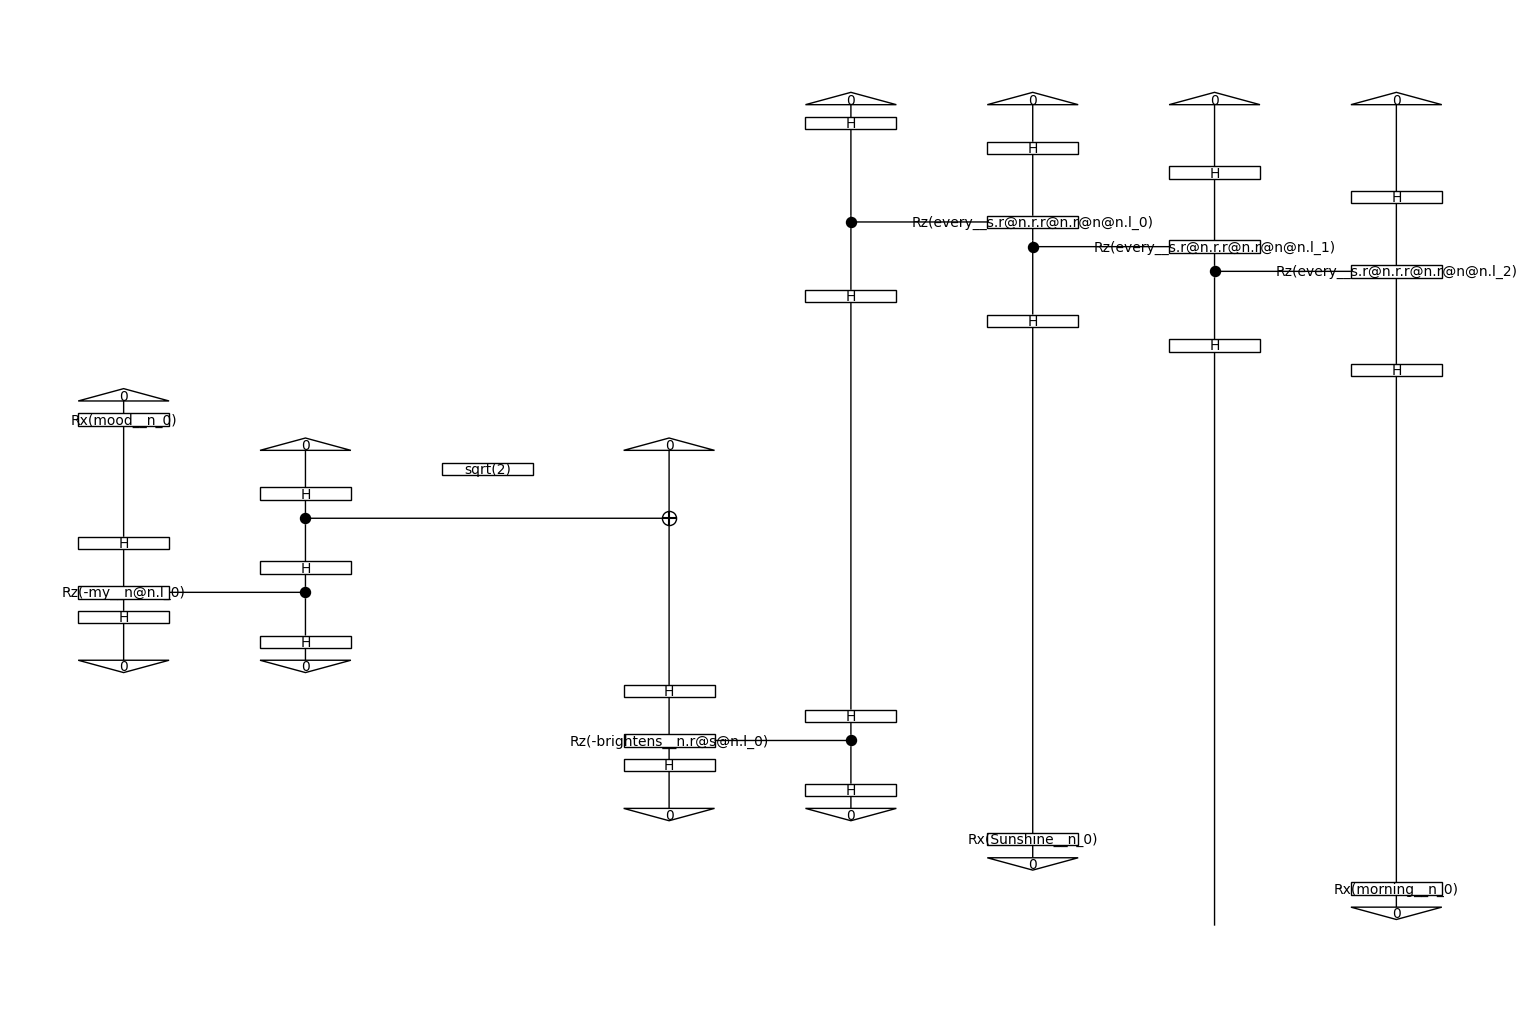

In [8]:
train_circuits[0].draw(figsize=(15,10))

I find this style of quantum circuit difficult to read, so I will convert it into an IBMQ circuit (strictly for visual purposes).

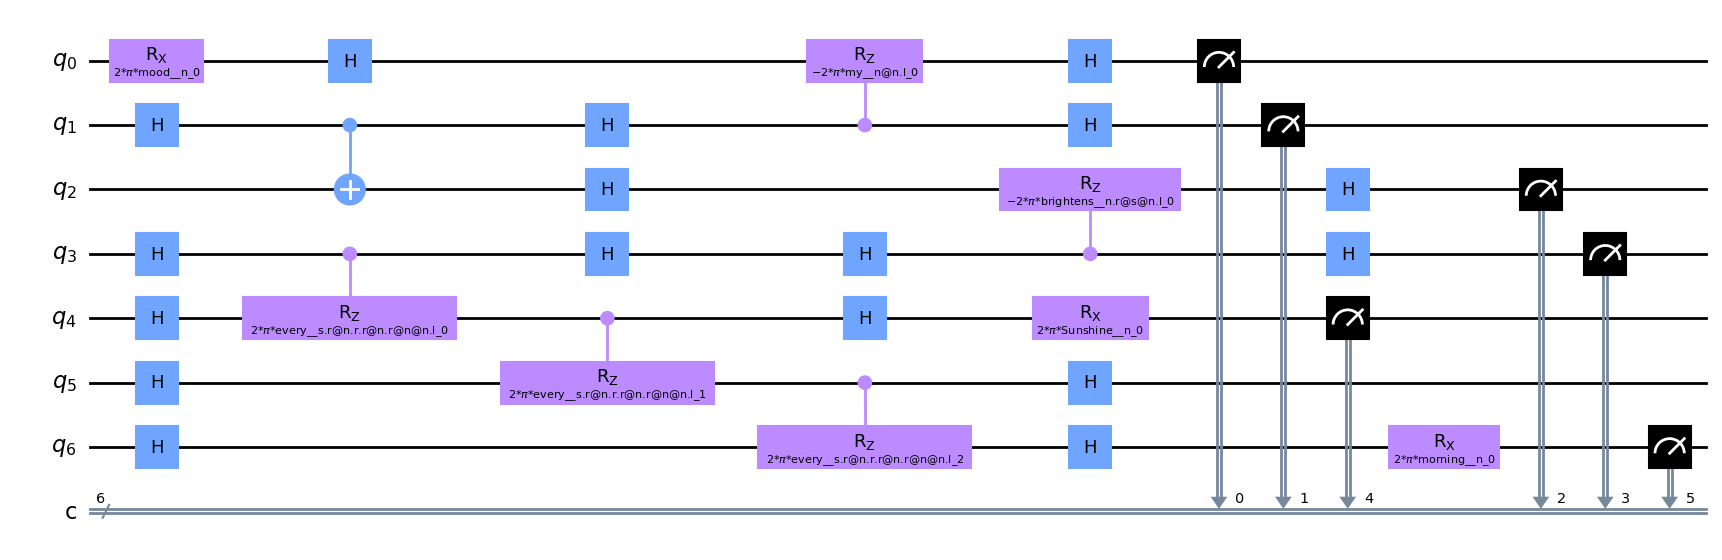

In [9]:
tket_circuit = train_circuits[0].to_tk()
qiskit_circuit = tk_to_qiskit(tket_circuit)
qiskit_circuit.draw(output='mpl')

You can see how each noun and sentence type, with their respective left and right adjoints, are now parameters for rotations within this circuit layout. Now we will initialize our model. For a numpy model, we can use Dask to distribute the training for ideal quantum simulation results. The Tket models can be trained using a snapshot of real noisy quantum hardware, but cannot be distributed.

In [10]:
all_circuits = train_circuits + test_circuits

'''
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)
model_name = 'TKET_Brisbane'
'''

model = NumpyModel.from_diagrams(all_circuits, distribution=True)
model_name = 'Dask_Model'

We now initialize the traininer with our model and remaining hyperparameters. For the Numpy model we can set *distribution=True* for the Dask implementation.

In [11]:
bce = BinaryCrossEntropyLoss()

acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
eval_metrics = {"acc": acc}


trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    log_dir='RelPron/logs',
    seed=0
)

Now we can train the model itself.

In [12]:
print(f"\n\nTraining {model_name} with n_words: {sentence_size}")
trainer.fit(train_dataset, test_dataset)
epoch_average = np.array(trainer.epoch_times).mean()



Training Dask_Model with n_words: 6


Epoch 1:    train/loss: 1.7306   valid/loss: 1.0340   train/acc: 0.4598   valid/acc: 0.5484
Epoch 2:    train/loss: 0.8344   valid/loss: 1.0402   train/acc: 0.4713   valid/acc: 0.5161
Epoch 3:    train/loss: 0.4458   valid/loss: 1.0470   train/acc: 0.4828   valid/acc: 0.5484
Epoch 4:    train/loss: 0.7697   valid/loss: 1.0705   train/acc: 0.4598   valid/acc: 0.5484
Epoch 5:    train/loss: 1.1318   valid/loss: 1.0335   train/acc: 0.5632   valid/acc: 0.5161
Epoch 6:    train/loss: 0.6639   valid/loss: 1.0387   train/acc: 0.5517   valid/acc: 0.4839
Epoch 7:    train/loss: 0.9033   valid/loss: 1.0459   train/acc: 0.5632   valid/acc: 0.4839
Epoch 8:    train/loss: 0.5654   valid/loss: 1.0674   train/acc: 0.6437   valid/acc: 0.4516
Epoch 9:    train/loss: 0.8913   valid/loss: 1.0678   train/acc: 0.5632   valid/acc: 0.4839
Epoch 10:   train/loss: 0.4382   valid/loss: 1.0989   train/acc: 0.6322   valid/acc: 0.4839
Epoch 11:   train/loss: 0.5649   valid/loss: 1.1016   train/acc: 0.6092   valid/

Epoch 91:   train/loss: 0.5525   valid/loss: 1.1778   train/acc: 0.7701   valid/acc: 0.5161
Epoch 92:   train/loss: 0.3453   valid/loss: 1.1806   train/acc: 0.8046   valid/acc: 0.5161
Epoch 93:   train/loss: 0.3079   valid/loss: 1.1791   train/acc: 0.8506   valid/acc: 0.5161
Epoch 94:   train/loss: 0.4337   valid/loss: 1.1786   train/acc: 0.8161   valid/acc: 0.5161
Epoch 95:   train/loss: 0.2353   valid/loss: 1.1781   train/acc: 0.8046   valid/acc: 0.5161
Epoch 96:   train/loss: 0.4620   valid/loss: 1.1836   train/acc: 0.7816   valid/acc: 0.5161
Epoch 97:   train/loss: 0.1994   valid/loss: 1.1889   train/acc: 0.8161   valid/acc: 0.5161
Epoch 98:   train/loss: 0.2416   valid/loss: 1.1868   train/acc: 0.7701   valid/acc: 0.5161
Epoch 99:   train/loss: 0.2462   valid/loss: 1.1840   train/acc: 0.8046   valid/acc: 0.5161
Epoch 100:  train/loss: 0.5255   valid/loss: 1.1857   train/acc: 0.8161   valid/acc: 0.5161

Training completed!


We can plot the training results below.

Text(1.4, 1.033967954725619, 'early stopping')

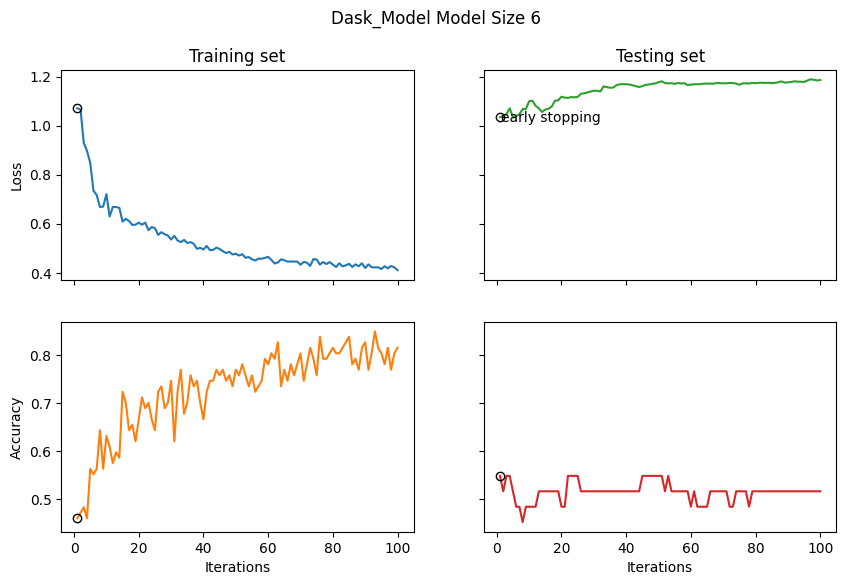

In [13]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
fig.suptitle(f'{model_name} Model Size {sentence_size}')
ax_tl.set_title('Training set')
ax_tr.set_title('Testing set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, len(trainer.train_epoch_costs)+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmax(trainer.val_eval_results)
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_tr.text(best_epoch + 1.4, trainer.val_costs[best_epoch], 'early stopping', va='center')